In [12]:
from QCutils import *
import numpy as np
import numpy as jnp

In [13]:
N = 4
beta = 1
J = 0.5
h = 0.3
sigma_z = np.array([[1,0],[0,-1]])
sigma_x = np.array([[0,1],[1,0]])
sigma_y = np.array([[0,1],[1,0]])

spin = np.array([0,1])
spin_up = np.array([[1],[0]])
spin_down= np.array([[0],[1]])

In [14]:
#def createH(J,h)

H = jnp.zeros((2**N,2**N))

initLattice = jnp.kron(sigma_z,sigma_z)
for i in range(2,N):
    initLattice = jnp.kron(initLattice,jnp.eye(2))

H += - J * initLattice

for lattice_point in range(1,N-1):
    curr = jnp.eye(2)
    for i in range(1,lattice_point):
        curr = jnp.kron(curr,jnp.eye(2))
    curr = jnp.kron( jnp.kron(curr,sigma_z),sigma_z)
    for i in range(lattice_point+2,N):
        curr = jnp.kron(curr,jnp.eye(2))
    
    assert curr.shape[0] == H.shape[0]
    
    H += -J * curr


initLattice = sigma_x
for i in range(1,N):
    initLattice = jnp.kron(initLattice,jnp.eye(2))

H += - h * initLattice

for lattice_point in range(1,N-1):
    curr = jnp.eye(2)
    for i in range(1,lattice_point):
        curr = jnp.kron(curr,jnp.eye(2))
    curr = jnp.kron(curr,sigma_x)
    for i in range(lattice_point+1,N):
        curr = jnp.kron(curr,jnp.eye(2))
    
    assert curr.shape[0] == H.shape[0]
    
    H += -h * curr

H = jnp.array(H,dtype=jnp.complex128)

In [15]:
formator = '{0:' + '0' + str(N)  +'b}'

state_in_str = [formator.format(i) for i in range(2**N)]

def state_to_vec(s):
    
    if s[0] == '1':
        state = spin_up
        state_mat = spin_up
    else:
        state = spin_down
        state_mat = spin_down
    
    for curr in s[1:]:
        if curr == '1':
            state = np.kron(state,spin_up)
            state_mat = np.hstack((state_mat,spin_up))
        else:
            state = np.kron(state,spin_down)
            state_mat = np.hstack((state_mat,spin_down))
    
    return state,state_mat

stateDict = dict()
for s in state_in_str:
    stateDict[s] = state_to_vec(s)[0]


In [16]:
def FCostFunc(QCresult):
    estF = 0
    for key in QCresult.keys():
        state = stateDict[key]
        prob = QCresult[key] / QuCircWithGrad.simShots
        estF += prob * (np.log(prob) + beta * state.T @ H @ state)
    return estF[0][0]


In [17]:
test1 = QuCircWithGrad(N)

'''
for i in range(N):
    test1.add_gate('Rx',i)

for layer in range(2):
    for i in range(N-1):
        test1.add_gate('Rxx',(i,i+1))
        test1.add_gate('Ryy',(i,i+1))
        test1.add_gate('Rzz',(i,i+1))

    for j in range(N-1):
        i = (N-2 - j)
        test1.add_gate('Rxx',(i,i+1))
        test1.add_gate('Ryy',(i,i+1))
        test1.add_gate('Rzz',(i,i+1))
'''
for layer in range(2):
    for i in range(N-1):
        test1.add_Arbitrary_gate((i,i+1))
    for j in range(N-1):
        i = (N-2 - j)
        test1.add_Arbitrary_gate((i,i+1))



In [18]:
test1.setCostFun(FCostFunc)
test1.construct()

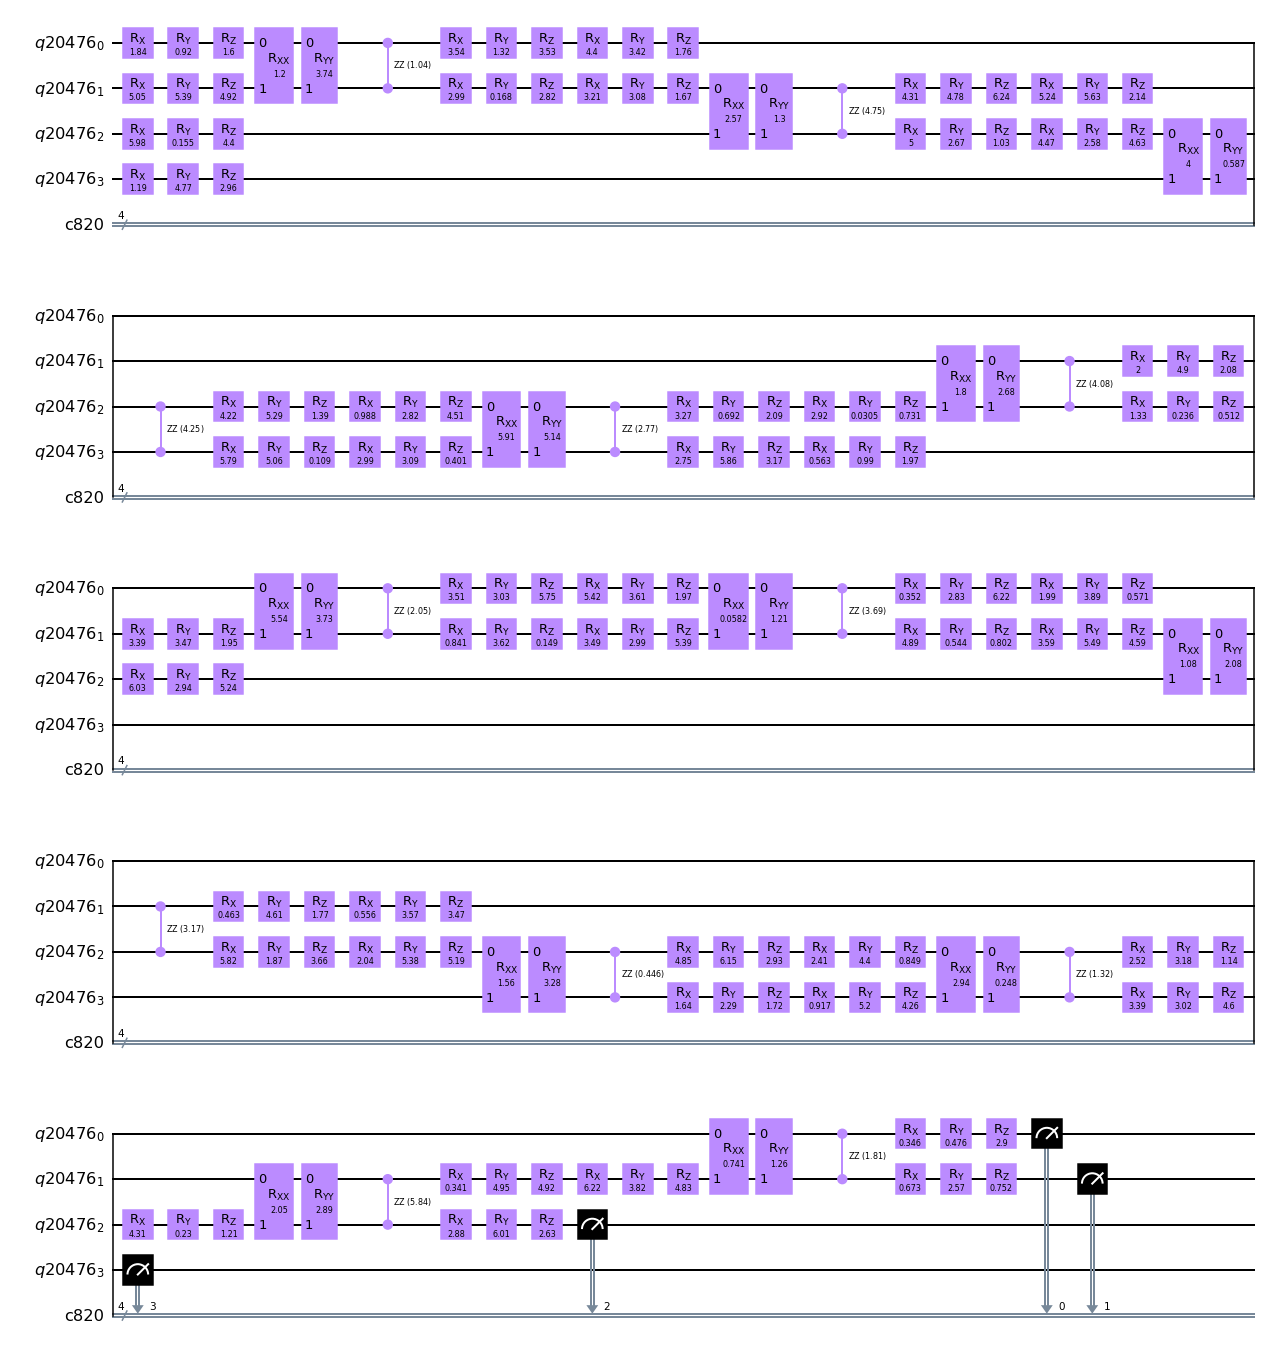

In [19]:
test1.qc.draw(output='mpl')

In [20]:
def ValandGrad(thetas):
    test1.updateThetas(thetas)
    return test1.calc(), test1.getThetaGrad()

In [21]:
import scipy.optimize
initThetas = 2* np.pi * np.random.rand(test1.size())
results = scipy.optimize.minimize(ValandGrad, initThetas,
                                  method='L-BFGS-B', jac=True)
print("success:", results.success, "\nniterations:", results.nit, "\nfinal loss:", results.fun)

success: True 
niterations: 6 
final loss: (-2.8658216029188437+0j)


In [22]:
from scipy.linalg import expm
-np.log(np.trace(expm(- beta * H)))

(-3.2502337399757737-0j)

In [21]:
learningRate = 0.05
maxStep = 100
record = np.zeros(maxStep)

thetas = 2* np.pi * np.random.rand(test1.size())

for i in range(maxStep):
    test1.updateThetas(thetas)
    record[i] = test1.calc()
    dTheta = test1.getThetaGrad()
    thetas -= learningRate * dTheta

/tmp/ipykernel_10766/1987415637.py:9: ComplexWarning: Casting complex values to real discards the imaginary part
  record[i] = test1.calc()


In [16]:
record[record != 0][0]

-1.9857282192311847

In [9]:
r = 0.5
circList = test1.genGradCircList()
thetaGrad = np.zeros(test1.size())

In [10]:
circPlus, circMinus = circList[1]

In [15]:
grad1 = r * (circPlus.calc() - circMinus.calc())
grad1[0][0]

(-0.276411996093495+0j)

In [11]:
circPlus, circMinus = circList[1]
grad1 = r * (circPlus.calc() - circMinus.calc())
thetaGrad[1] = grad1


In [9]:
lst = test1.genGradCircList()

In [12]:
len(lst)
circPlus, circMinus = lst[0]

In [16]:
circMinus.calc()
grad = 0.5 * (circPlus.calc() - circMinus.calc())
grad

/Users/qwe/miniforge3/envs/qi/lib/python3.10/site-packages/numpy/linalg/linalg.py:2146: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/qwe/miniforge3/envs/qi/lib/python3.10/site-packages/numpy/linalg/linalg.py:2146: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


array([[-0.01312868+0.j]])

In [ ]:
test1.getThetaGrad()